In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Preprocessing

## Importing Library

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline

## Importing the dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv") # train dataset
test_df = pd.read_csv("/kaggle/input/titanic/test.csv") # test dataset
submit = pd.read_csv("/kaggle/input/titanic/gender_submission.csv") # submit dataset

## Exploratory Data Analysis

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
all_df = pd.concat([train_df,test_df], axis = 0)
all_df.set_index('PassengerId',inplace = True)

In [8]:
all_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


In [10]:
all_df.shape

(1309, 11)

In [11]:
submit.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [12]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [13]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Drop Unwanted Columns

#### Since there are some features that don't affect model training such as Name, Cabin, and Ticket, they need to be removed.

In [14]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
train_df = train_df.drop(["Name","Cabin","Ticket", "PassengerId"],axis=1)
test_df = test_df.drop(["Name","Cabin","Ticket", "PassengerId"],axis=1)

In [16]:
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [17]:
test_df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

### Checking Missing Values

In [18]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [19]:
test_df.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

### Checking the correlation of the features

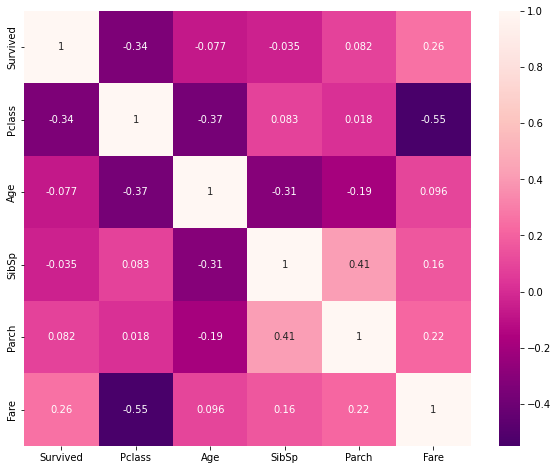

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(data = train_df.corr(), annot = True, cmap = 'RdPu_r')
plt.show()

#### From this observation Fare and Parch are the most correlated features with Survived features with a score of 26% and 8.2% compared to other features, Fare and Parch features can be used to predict the survivors.

# Taking Care of Missing Data

In [21]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [22]:
test_df.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [23]:
# Fill the missing data with the mean value of the columns
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mean())



In [24]:
train_df["Age"].fillna(np.random.choice(train_df['Age'][~train_df['Age'].isna()]),inplace = True)


test_df["Age"].fillna(np.random.choice(train_df['Age'][~train_df['Age'].isna()]),inplace = True)
test_df["Fare"].fillna(np.random.choice(train_df['Fare'][~train_df['Fare'].isna()]),inplace = True)

In [25]:
train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [26]:
test_df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [27]:
train_df = train_df.dropna()

# Encoding Categorical Data

## Label Encoding

In [28]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [29]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [30]:
# Change the values of sex column to categorical values
train_df['Sex'].replace({'male':0,'female':1},inplace=True)
test_df['Sex'].replace({'male':0,'female':1},inplace=True)

In [31]:
train_df["Sex"] = train_df["Sex"].astype(str).astype(float)
test_df["Sex"] = test_df["Sex"].astype(str).astype(float)

In [32]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.0,22.0,1,0,7.2500,S
1,1,1,1.0,38.0,1,0,71.2833,C
2,1,3,1.0,26.0,0,0,7.9250,S
3,1,1,1.0,35.0,1,0,53.1000,S
4,0,3,0.0,35.0,0,0,8.0500,S


In [33]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0.0,34.5,0,0,7.8292,Q
1,3,1.0,47.0,1,0,7.0000,S
2,2,0.0,62.0,0,0,9.6875,Q
3,3,0.0,27.0,0,0,8.6625,S
4,3,1.0,22.0,1,1,12.2875,S


### Ordered Integer Encoding

In [34]:
train_df['Embarked'].replace({'S':1,'C':2,'Q':3},inplace=True)
test_df['Embarked'].replace({'S':1,'C':2,'Q':3},inplace=True)

In [35]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.0,22.0,1,0,7.2500,1
1,1,1,1.0,38.0,1,0,71.2833,2
2,1,3,1.0,26.0,0,0,7.9250,1
3,1,1,1.0,35.0,1,0,53.1000,1
4,0,3,0.0,35.0,0,0,8.0500,1


In [36]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0.0,34.5,0,0,7.8292,3
1,3,1.0,47.0,1,0,7.0000,1
2,2,0.0,62.0,0,0,9.6875,3
3,3,0.0,27.0,0,0,8.6625,1
4,3,1.0,22.0,1,1,12.2875,1


# Modelling


## Setting up variables to train the model

In [37]:
X = train_df.drop(['Survived'],axis='columns')
y = train_df['Survived']

## Splitting the dataset into the Training set and Test set

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [39]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
364,3,0.0,29.699118,1,0,15.5000,3
256,1,1.0,29.699118,0,0,79.2000,2
477,3,0.0,29.000000,1,0,7.0458,1
272,2,1.0,41.000000,0,1,19.5000,1
554,3,1.0,22.000000,0,0,7.7750,1
...,...,...,...,...,...,...,...
837,3,0.0,29.699118,0,0,8.0500,1
193,2,0.0,3.000000,1,1,26.0000,1
630,1,0.0,80.000000,0,0,30.0000,1
560,3,0.0,29.699118,0,0,7.7500,3


# Training several models on training set

## Logistic Regression

In [40]:
model1 = LogisticRegression(random_state=0)
model1.fit(X_train,y_train)
pred = model1.predict(X_test)
log_cm = confusion_matrix(y_test, pred)
log_acc = accuracy_score(pred,y_test)
print(log_cm)
print(log_acc)

[[84 21]
 [29 44]]
0.7191011235955056


## K-NN

In [41]:
model2 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
model2.fit(X_train, y_train)
pred_2 = model2.predict(X_test)
knn_cm = confusion_matrix(y_test, pred_2)
knn_acc = accuracy_score(pred_2,y_test)
print(knn_cm)
print(knn_acc)

[[77 28]
 [31 42]]
0.6685393258426966


## Support Vector Machine (SVM)

In [42]:
model3 = SVC(kernel = 'linear', random_state = 0)
model3.fit(X_train, y_train)
pred_3 = model3.predict(X_test)
svm_cm = confusion_matrix(y_test, pred_3)
svm_acc = accuracy_score(pred_3,y_test)
print(svm_cm)
print(svm_acc)

[[85 20]
 [30 43]]
0.7191011235955056


## Decision Tree Classifier

In [43]:
model4 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
model4.fit(X_train, y_train)
pred_4 = model4.predict(X_test)
dt_cm = confusion_matrix(y_test, pred_4)
dt_acc = accuracy_score(pred_4,y_test)
print(dt_cm)
print(dt_acc)

[[87 18]
 [25 48]]
0.7584269662921348


## Random Forrest Classifier

In [44]:
model5 = RandomForestClassifier(n_estimators = 50)
model5.fit(X_train,y_train)
pred_5 = model5.predict(X_test)
rf_cm = confusion_matrix(y_test, pred_5)
rf_acc = accuracy_score(pred_5,y_test)
print(rf_cm)
print(rf_acc)

[[90 15]
 [25 48]]
0.7752808988764045


## XGBoost Classifier

In [45]:
model6 = XGBClassifier()
model6.fit(X_train, y_train)
pred_6 = model6.predict(X_test)
xg_cm = confusion_matrix(y_test, pred_6)
xg_acc = accuracy_score(pred_6,y_test);
print(xg_cm)
print(xg_acc)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[86 19]
 [25 48]]
0.7528089887640449


Accuracy of Logistic Regression :  0.7191011235955056
Accuracy of KNN Classifier :  0.6685393258426966
Accuracy of SVM Classifier :  0.7191011235955056
Accuracy of Decision Tree Classifier :  0.7584269662921348
Accuracy of Random Forest Classifier :  0.7752808988764045
Accuracy of XGBoost Classifier :  0.7528089887640449


(0.6, 1.0)

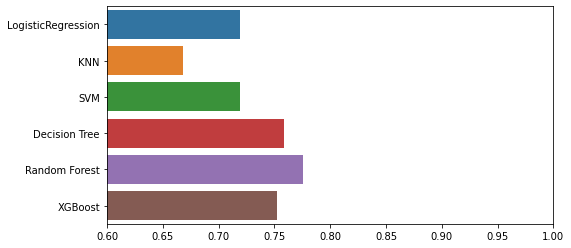

In [46]:
print("Accuracy of Logistic Regression : ",log_acc)
print("Accuracy of KNN Classifier : ",knn_acc)
print("Accuracy of SVM Classifier : ",svm_acc)
print("Accuracy of Decision Tree Classifier : ",dt_acc)
print("Accuracy of Random Forest Classifier : ",rf_acc)
print("Accuracy of XGBoost Classifier : ",xg_acc)
models_acc=[log_acc,knn_acc,svm_acc,dt_acc,rf_acc,xg_acc]
names_of_models=['LogisticRegression','KNN','SVM','Decision Tree', 'Random Forest', 'XGBoost']
sns.barplot(y=names_of_models,x=models_acc)
plt.gcf().set_size_inches(8,4)
plt.xlim([0.6,1.0])

# Selecting the best model for predicting

In [47]:
model5.fit(X,y)

RandomForestClassifier(n_estimators=50)

In [48]:
pred = model5.predict(test_df)

In [49]:
submission = pd.DataFrame({"PassengerId": submit["PassengerId"],"Survived":pred})

In [50]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [51]:
submission.to_csv('submission.csv',index=False)

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

In [53]:
#Using MLPClassifier
sc = StandardScaler()
scaler = sc.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mlp = MLPClassifier()
mlp = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,50,30)).fit(X_train, y_train)
y_pred=mlp.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7303370786516854
